There are 4 types of energy to predict <br>
    - 0 : electricity
    - 1 : chilledwater
    - 2 : steam
    - 3 : hotwater

Electricity and water consumption may have different behavior!<br>
     - I will make separately train & predict the model

* Reference 
 - https://www.kaggle.com/corochann/ashrae-training-lgbm-by-meter-type
 - https://www.kaggle.com/caesarlupum/ashrae-start-here-a-gentle-introduction



In [1]:
# No leak data
import pandas as pd
import numpy as np
import gc 
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
%%time
# 파일 읽어오기
train_df = pd.read_csv('train.csv')
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'], format = '%Y-%m-%d %H:%M:%S')
weather_train_df = pd.read_csv('weather_train.csv')


test_df = pd.read_csv('test.csv')
test_df['timestamp'] = pd.to_datetime(test_df['timestamp'], format = '%Y-%m-%d %H:%M:%S')

weather_test_df = pd.read_csv('weather_test.csv')
building_meta_df = pd.read_csv('building_metadata.csv')
sample_submission = pd.read_csv('sample_submission.csv')

Wall time: 58.4 s


In [3]:
# Glimpse of Data
print(train_df.shape)
print(weather_train_df.shape)
print(weather_test_df.shape)
print(building_meta_df.shape)

print(test_df.shape)

(20216100, 4)
(139773, 9)
(277243, 9)
(1449, 6)
(41697600, 4)


In [4]:
# ㅒ

In [5]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [6]:
# Reducing memory
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

weather_train_df = reduce_mem_usage(weather_train_df)
weather_test_df = reduce_mem_usage(weather_test_df)
building_meta_df = reduce_mem_usage(building_meta_df)

Mem. usage decreased to 289.19 Mb (53.1% reduction)
Mem. usage decreased to 596.49 Mb (53.1% reduction)
Mem. usage decreased to  3.07 Mb (68.1% reduction)
Mem. usage decreased to  6.08 Mb (68.1% reduction)
Mem. usage decreased to  0.03 Mb (60.3% reduction)


In [7]:
def plot_date_usage(train_df, meter=0, building_id=0):
    train_temp_df = train_df[train_df['meter'] == meter]
    train_temp_df = train_temp_df[train_temp_df['building_id'] == building_id]    
    train_temp_df_meter = train_temp_df.groupby('date')['meter_reading_log1p'].sum()
    train_temp_df_meter = train_temp_df_meter.to_frame().reset_index()
    fig = px.line(train_temp_df_meter, x='date', y='meter_reading_log1p')
    fig.show()

## Feature engineering 
  - There are 3 parts to make features <br>
      train_df / weather_train_df / building_meta_df
  - and then I will merge them 

In [8]:
# train_df -- timestamp : 월 , 주, 일

train_df['meter_reading_log1p'] = np.log1p(train_df['meter_reading'])
# train_df['meter_reading']
# date / 월 / 주 /일 
train_df['date'] = train_df['timestamp'].dt.date
train_df['hour'] = train_df['timestamp'].dt.hour
train_df['weekend'] = train_df['timestamp'].dt.weekday
train_df['month'] = train_df['timestamp'].dt.month
train_df['dayofweek'] = train_df['timestamp'].dt.dayofweek


test_df['date'] = test_df['timestamp'].dt.date
test_df['hour'] = test_df['timestamp'].dt.hour
test_df['weekend'] = test_df['timestamp'].dt.weekday
test_df['month'] = test_df['timestamp'].dt.month
test_df['dayofweek'] = test_df['timestamp'].dt.dayofweek



In [9]:
# isholiday
holidays = ["2016-01-01", "2016-01-18", "2016-02-15", "2016-05-30", "2016-07-04",
                "2016-09-05", "2016-10-10", "2016-11-11", "2016-11-24", "2016-12-26",
                "2017-01-01", "2017-01-16", "2017-02-20", "2017-05-29", "2017-07-04",
                "2017-09-04", "2017-10-09", "2017-11-10", "2017-11-23", "2017-12-25",
                "2018-01-01", "2018-01-15", "2018-02-19", "2018-05-28", "2018-07-04",
                "2018-09-03", "2018-10-08", "2018-11-12", "2018-11-22", "2018-12-25",
                "2019-01-01"]

train_df["is_holiday"] = (train_df.timestamp.dt.date.astype("str").isin(holidays)).astype(int)
test_df["is_holiday"] = (test_df.timestamp.dt.date.astype("str").isin(holidays)).astype(int)

In [10]:
#Outlier 제거 
# Remove outliers
train_df = train_df [ train_df['building_id'] != 1099 ]
train_df = train_df.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')

In [11]:

weather_train_df.isnull().sum()

site_id                   0
timestamp                 0
air_temperature          55
cloud_coverage        69173
dew_temperature         113
precip_depth_1_hr     50289
sea_level_pressure    10618
wind_direction         6268
wind_speed              304
dtype: int64

In [12]:
# weather - 
# weather data has a lot of nulls 
# I tried to fill these values by interpolating data
# df.groupby('').apply(lambda group: group.interpolate~~)

weather_train_df.head()
weather_train_df = weather_train_df.groupby('site_id').apply\
                    (lambda group : group.interpolate(limit_direction='both'))
weather_test_df = weather_test_df.groupby('site_id').apply\
                    (lambda group : group.interpolate(limit_direction='both'))

In [13]:

weather_train_df.isnull().sum()

site_id                   0
timestamp                 0
air_temperature           0
cloud_coverage        17228
dew_temperature           0
precip_depth_1_hr     26273
sea_level_pressure     8755
wind_direction            0
wind_speed                0
dtype: int64

In [14]:
# lags 
# site 별로 최근 3일간의 날씨를 rolling 하기
def add_lag_feature(weather_df, window=3):
    group_df = weather_df.groupby('site_id')
    cols = ['air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']
    rolled = group_df[cols].rolling(window=window, min_periods=0)
    lag_mean = rolled.mean().reset_index().astype(np.float16)
    lag_max = rolled.max().reset_index().astype(np.float16)
    lag_min = rolled.min().reset_index().astype(np.float16)
    lag_std = rolled.std().reset_index().astype(np.float16)
    for col in cols:
        weather_df[f'{col}_mean_lag{window}'] = lag_mean[col]
        weather_df[f'{col}_max_lag{window}'] = lag_max[col]
        weather_df[f'{col}_min_lag{window}'] = lag_min[col]
        weather_df[f'{col}_std_lag{window}'] = lag_std[col]

In [15]:
add_lag_feature(weather_train_df, window=3)
add_lag_feature(weather_train_df, window=72)
add_lag_feature(weather_test_df, window=3)
add_lag_feature(weather_test_df, window=72)

In [16]:
# # meter reading 값에 대한 aggregation
# 과적합 문제를 야기할 수 있다.
# df_group = train_df.groupby('building_id')['meter_reading_log1p']
# building_mean = df_group.mean().astype(np.float16)
# building_median = df_group.median().astype(np.float16)
# building_min = df_group.min().astype(np.float16)
# building_max = df_group.max().astype(np.float16)
# building_std = df_group.std().astype(np.float16)

# train_df['building_mean'] = train_df['building_id'].map(building_mean)
# train_df['building_median'] = train_df['building_id'].map(building_median)
# train_df['building_min'] = train_df['building_id'].map(building_min)
# train_df['building_max'] = train_df['building_id'].map(building_max)
# train_df['building_std'] = train_df['building_id'].map(building_std)

In [17]:
# Removing weired data on site_id =0  
#https://www.kaggle.com/c/ashrae-energy-prediction/discussion/113054#656588
# building_meta_df[building_meta_df.site_id == 0]

### Merge


In [18]:
# 하나에 합치기

# base + building_meta_df 합치기
train_df = pd.merge(train_df,building_meta_df, on= ['building_id'],how='left')
test_df = pd.merge(test_df,building_meta_df, on= ['building_id'],how='left')
# del building_meta_df

In [19]:
# base + weather_train_df 합치기
weather_train_df['timestamp'] = pd.to_datetime(weather_train_df['timestamp'], format = '%Y-%m-%d %H:%M:%S')
weather_test_df['timestamp'] = pd.to_datetime(weather_test_df['timestamp'], format = '%Y-%m-%d %H:%M:%S')

train_df = pd.merge(train_df,weather_train_df, on= ['site_id','timestamp'],how='left')
test_df = pd.merge(test_df,weather_test_df, on= ['site_id','timestamp'],how='left')
# del weather_train_df, weather_test_df

In [20]:
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.model_selection import train_test_split

### Encoding



In [21]:
#Encoidng variables
le = LabelEncoder()
# train_df['primary_use'] = train_df['primary_use'].astype(str)
train_df['primary_use'] = le.fit_transform(train_df['primary_use']).astype(np.int8)

# test_df['primary_use'] = test_df['primary_use'].astype(str)
test_df['primary_use'] = le.fit_transform(test_df['primary_use']).astype(np.int8)

In [22]:
# Pickle 저장

train_df.to_pickle('train_df.pkl')
test_df.to_pickle('test_df.pkl')
del train_df, test_df
gc.collect()



14

In [23]:
train_df = pd.read_pickle('train_df.pkl')
test_df = pd.read_pickle('test_df.pkl')

In [24]:
# some feature enginnering

train_df['age'] = train_df['year_built'].max()-train_df['year_built']+1
test_df['age'] = test_df['year_built'].max() - test_df['year_built'] + 1

In [25]:
#Handling missing values
# To streamline this though process it is useful to know the 3 categories in which missing data can be classified into:

# Missing Completely at Random (MCAR)
# Missing at Random (MAR)
# Missing Not at Random (MNAR)

train_df['floor_count'] = train_df['floor_count'].fillna(-999).astype(np.int16)
test_df['floor_count'] = test_df['floor_count'].fillna(-999).astype(np.int16)

train_df['year_built'] = train_df['year_built'].fillna(-999).astype(np.int16)
test_df['year_built'] = test_df['year_built'].fillna(-999).astype(np.int16)

train_df['age'] = train_df['age'].fillna(-999).astype(np.int16)
test_df['age'] = test_df['age'].fillna(-999).astype(np.int16)

train_df['cloud_coverage'] = train_df['cloud_coverage'].fillna(-999).astype(np.int16)
test_df['cloud_coverage'] = test_df['cloud_coverage'].fillna(-999).astype(np.int16) 


In [26]:
drop_cols = ['date',"precip_depth_1_hr", "sea_level_pressure", "wind_direction", "wind_speed","timestamp"]
target = train_df["meter_reading_log1p"]
del train_df["meter_reading"], train_df['meter_reading_log1p']
train_df = train_df.drop(drop_cols, axis=1)
drop_cols += ["row_id"]
# drop_cols.remove('date')
test_df = test_df.drop(drop_cols, axis=1)

In [27]:
train_df.head()
categorical_features = ["building_id", "site_id", "meter", "hour", "weekend",'month','is_holiday','primary_use']

In [28]:
import lightgbm as lgb
from sklearn.model_selection import KFold
# lightbgm
# params = {
#     'boosting_type': 'gbdt',
#     'objective': 'regression',
#     'metric': {'l2'},
# #     'subsample': 0.2,
#     'learning_rate': 0.08,
#     'feature_fraction': 0.9,
#     'bagging_fraction': 0.9,
# #     'alpha': 0.1,
# #     'lambda': 0.1,
# #     'n_jobs' :2 
# }

params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 1280,
    "learning_rate": 0.05,
    "feature_fraction": 0.85,
    "reg_lambda": 2,
    "metric": "rmse",
    
}

In [29]:
from sklearn.metrics import mean_squared_log_error


In [36]:
%%time
folds = 3
seed = 99 #666
# shuffle = False
kf = KFold(n_splits=folds, shuffle=False, random_state=seed)
scores = [] 
models = []
for train_index, val_index in kf.split(train_df):
    train_X = train_df.iloc[train_index]
    val_X = train_df.iloc[val_index]
    train_y = target.iloc[train_index]
    val_y = target.iloc[val_index]
    lgb_train = lgb.Dataset(train_X, train_y,categorical_feature=categorical_features)
    lgb_eval = lgb.Dataset(val_X, val_y,categorical_feature=categorical_features)
    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=1000, #300,
                    valid_sets=(lgb_train, lgb_eval),
#                     feval=rmsle,
                    early_stopping_rounds= 50,#100,
                    verbose_eval=30) #100)
#     model.pred#ict(test_df.iloc[i:i + step_size])
    
    
    # CV Score 만들기
    scores.append(gbm.predict(val_X))
    #MSLE
#scores.append( np.sqrt(mean_squared_log_error( np.expm1(val_y), np.expm1(predictions) )))
    
    models.append(gbm)
    del gbm

C:\Users\yseon\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[30]	training's rmse: 0.928251	valid_1's rmse: 1.17631
[60]	training's rmse: 0.705894	valid_1's rmse: 1.06115
[90]	training's rmse: 0.630757	valid_1's rmse: 1.03737
[120]	training's rmse: 0.581884	valid_1's rmse: 1.02652
[150]	training's rmse: 0.552784	valid_1's rmse: 1.02404
[180]	training's rmse: 0.53285	valid_1's rmse: 1.02291
[210]	training's rmse: 0.518196	valid_1's rmse: 1.02238
[240]	training's rmse: 0.507422	valid_1's rmse: 1.02164
[270]	training's rmse: 0.498126	valid_1's rmse: 1.02104
[300]	training's rmse: 0.490581	valid_1's rmse: 1.02086
[330]	training's rmse: 0.48393	valid_1's rmse: 1.02062
[360]	training's rmse: 0.477948	valid_1's rmse: 1.0207
[390]	training's rmse: 0.471905	valid_1's rmse: 1.02035
[420]	training's rmse: 0.466493	valid_1's rmse: 1.02017
[450]	training's rmse: 0.461815	valid_1's rmse: 1.02013
[480]	training's rmse: 0.457429	valid_1's rmse: 1.02001
[510]	training's rmse: 0.453215	valid_1's rmse: 1

In [37]:
#("CV Score(MSLE)  : ", np.round(np.mean(scores),3))

In [46]:
models[-1]

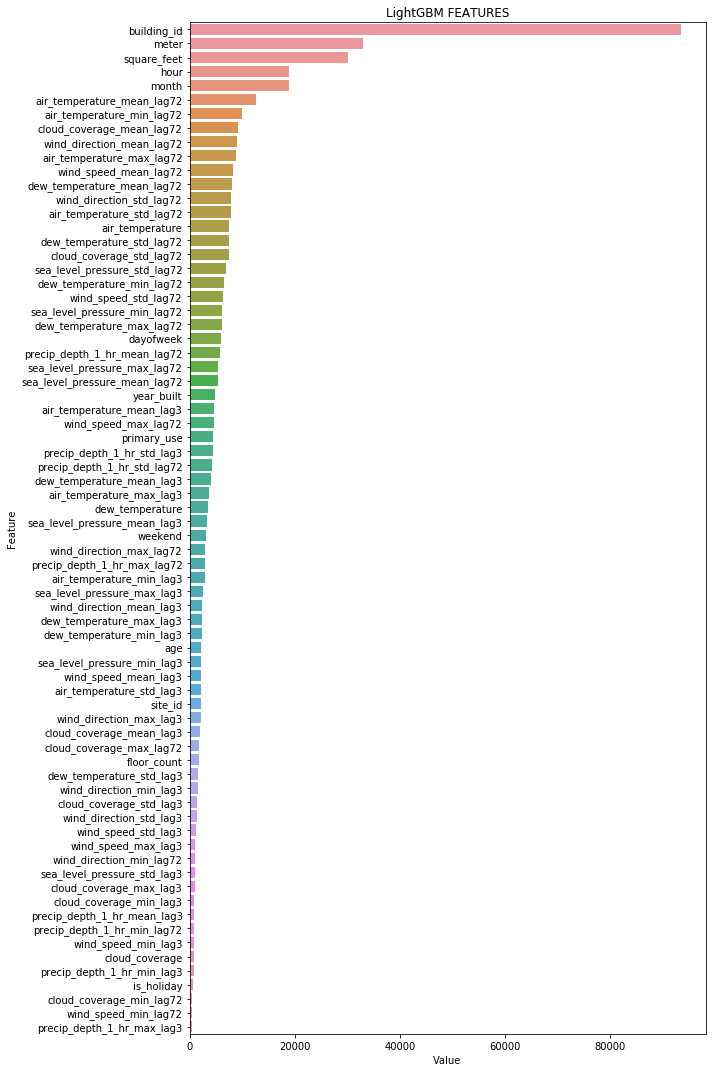

Wall time: 919 ms


In [48]:
%%time
import matplotlib.pyplot as plt
import seaborn as sns

gbm = models[-1]
feature_imp = pd.DataFrame(sorted(zip(gbm.feature_importance(), gbm.feature_name()),reverse = True), columns=['Value','Feature'])
plt.figure(figsize=(10, 15))

sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM FEATURES')
plt.tight_layout()
plt.show()

In [87]:
%%time
i = 0
res = []
res2 = []
res3 = []
step_size = 50000
for j in tqdm(range(int(np.ceil(test_df.shape[0] / 50000)))):
#     # 평균을 내고 나서 exp를 취하는 코드
    res.append(np.expm1(sum([model.predict(test_df.iloc[i:i + step_size]) for model in models]) / folds))
    # exp를 취하고 평균을 내는 코드 https://www.kaggle.com/rohanrao/ashrae-half-and-half
    res2.append(sum([np.expm1(model.predict(test_df.iloc[i:i + step_size])) for model in models])/ folds)
    res3.append([np.expm1(model.predict(test_df.iloc[i:i + step_size])) for model in models])
    
    i += step_size







  0%|                                                                                          | 0/834 [00:00<?, ?it/s]





  0%|                                                                                  | 1/834 [00:01<27:37,  1.99s/it]





  0%|▏                                                                                 | 2/834 [00:03<27:28,  1.98s/it]





  0%|▎                                                                                 | 3/834 [00:05<27:29,  1.98s/it]





  0%|▍                                                                                 | 4/834 [00:07<27:44,  2.01s/it]





  1%|▍                                                                                 | 5/834 [00:09<27:37,  2.00s/it]





  1%|▌                                                                                 | 6/834 [00:12<27:48,  2.01s/it]





  1%|▋                                                                                 | 7/834 [00:14<27:42,  2.01s/it]

 16%|████████████▍                                                                   | 130/834 [04:22<24:17,  2.07s/it]





 16%|████████████▌                                                                   | 131/834 [04:24<24:18,  2.07s/it]





 16%|████████████▋                                                                   | 132/834 [04:26<24:24,  2.09s/it]





 16%|████████████▊                                                                   | 133/834 [04:28<24:10,  2.07s/it]





 16%|████████████▊                                                                   | 134/834 [04:30<24:07,  2.07s/it]





 16%|████████████▉                                                                   | 135/834 [04:32<24:09,  2.07s/it]





 16%|█████████████                                                                   | 136/834 [04:34<23:59,  2.06s/it]





 16%|█████████████▏                                                                  | 137/834 [04:36<23:56,  2.06s/it]







 31%|████████████████████████▉                                                       | 260/834 [08:47<19:34,  2.05s/it]





 31%|█████████████████████████                                                       | 261/834 [08:49<19:28,  2.04s/it]





 31%|█████████████████████████▏                                                      | 262/834 [08:51<19:17,  2.02s/it]





 32%|█████████████████████████▏                                                      | 263/834 [08:53<19:28,  2.05s/it]





 32%|█████████████████████████▎                                                      | 264/834 [08:56<19:27,  2.05s/it]





 32%|█████████████████████████▍                                                      | 265/834 [08:58<19:29,  2.06s/it]





 32%|█████████████████████████▌                                                      | 266/834 [09:00<19:28,  2.06s/it]





 32%|█████████████████████████▌                                                      | 267/834 [09:02<19:30,  2.06s/it]







 47%|█████████████████████████████████████▍                                          | 390/834 [13:07<14:05,  1.90s/it]





 47%|█████████████████████████████████████▌                                          | 391/834 [13:09<14:08,  1.92s/it]





 47%|█████████████████████████████████████▌                                          | 392/834 [13:11<14:12,  1.93s/it]





 47%|█████████████████████████████████████▋                                          | 393/834 [13:13<14:21,  1.95s/it]





 47%|█████████████████████████████████████▊                                          | 394/834 [13:15<14:39,  2.00s/it]





 47%|█████████████████████████████████████▉                                          | 395/834 [13:17<14:49,  2.03s/it]





 47%|█████████████████████████████████████▉                                          | 396/834 [13:19<14:51,  2.04s/it]





 48%|██████████████████████████████████████                                          | 397/834 [13:21<14:49,  2.04s/it]







 62%|█████████████████████████████████████████████████▉                              | 520/834 [17:34<10:30,  2.01s/it]





 62%|█████████████████████████████████████████████████▉                              | 521/834 [17:36<10:17,  1.97s/it]





 63%|██████████████████████████████████████████████████                              | 522/834 [17:38<10:17,  1.98s/it]





 63%|██████████████████████████████████████████████████▏                             | 523/834 [17:40<10:18,  1.99s/it]





 63%|██████████████████████████████████████████████████▎                             | 524/834 [17:42<10:13,  1.98s/it]





 63%|██████████████████████████████████████████████████▎                             | 525/834 [17:44<10:13,  1.98s/it]





 63%|██████████████████████████████████████████████████▍                             | 526/834 [17:46<10:15,  2.00s/it]





 63%|██████████████████████████████████████████████████▌                             | 527/834 [17:48<10:15,  2.01s/it]







 78%|██████████████████████████████████████████████████████████████▎                 | 650/834 [21:57<06:09,  2.01s/it]





 78%|██████████████████████████████████████████████████████████████▍                 | 651/834 [21:59<06:06,  2.00s/it]





 78%|██████████████████████████████████████████████████████████████▌                 | 652/834 [22:01<06:03,  2.00s/it]





 78%|██████████████████████████████████████████████████████████████▋                 | 653/834 [22:03<05:59,  1.99s/it]





 78%|██████████████████████████████████████████████████████████████▋                 | 654/834 [22:05<06:01,  2.01s/it]





 79%|██████████████████████████████████████████████████████████████▊                 | 655/834 [22:07<06:00,  2.01s/it]





 79%|██████████████████████████████████████████████████████████████▉                 | 656/834 [22:09<05:59,  2.02s/it]





 79%|███████████████████████████████████████████████████████████████                 | 657/834 [22:11<05:59,  2.03s/it]







 94%|██████████████████████████████████████████████████████████████████████████▊     | 780/834 [26:18<01:49,  2.04s/it]





 94%|██████████████████████████████████████████████████████████████████████████▉     | 781/834 [26:20<01:46,  2.01s/it]





 94%|███████████████████████████████████████████████████████████████████████████     | 782/834 [26:22<01:43,  2.00s/it]





 94%|███████████████████████████████████████████████████████████████████████████     | 783/834 [26:24<01:41,  1.99s/it]





 94%|███████████████████████████████████████████████████████████████████████████▏    | 784/834 [26:26<01:39,  1.98s/it]





 94%|███████████████████████████████████████████████████████████████████████████▎    | 785/834 [26:28<01:36,  1.97s/it]





 94%|███████████████████████████████████████████████████████████████████████████▍    | 786/834 [26:30<01:33,  1.96s/it]





 94%|███████████████████████████████████████████████████████████████████████████▍    | 787/834 [26:31<01:30,  1.92s/it]







Wall time: 28min 5s


In [40]:
%%time
from datetime import datetime

res = np.concatenate(res)
sample_submission["meter_reading"] = res
sample_submission.loc[sample_submission['meter_reading'] < 0, 'meter_reading'] = 0
sample_submission.to_csv('avg_exp_sub_' + str(datetime.now().strftime('%Y-%m-%d_%H-%M-%S')) + '.csv', index=False)
sample_submission.head(10)

Wall time: 1min 51s


,row_id,meter_reading
0,0,127.965366
1,1,60.174680
2,2,9.872214
3,3,243.934492
4,4,970.634762
5,5,13.840540
6,6,87.368447
7,7,411.868529
8,8,243.727197
9,9,218.072341


In [41]:
%%time

res2 = np.concatenate(res2)
sample_submission["meter_reading"] = res2
sample_submission.loc[sample_submission['meter_reading'] < 0, 'meter_reading'] = 0
sample_submission.to_csv('exp_avg_sub_' + str(datetime.now().strftime('%Y-%m-%d_%H-%M-%S')) + '.csv', index=False)
sample_submission.head(10)

Wall time: 1min 52s


,row_id,meter_reading
0,0,134.855900
1,1,62.784090
2,2,9.874667
3,3,263.478222
4,4,1001.038997
5,5,13.930367
6,6,94.685406
7,7,414.965055
8,8,309.773377
9,9,244.768380


In [88]:
%%time
# 최근 데이터에 가중치를 더 주는 코드 
res4 = []
for i in range(len(res3)):
    res4.append((0.6*res3[i][0]+0.3*res3[i][1]+0.1*res3[i][2]))

res4 = np.concatenate(res4)
sample_submission["meter_reading"] = res4
sample_submission.loc[sample_submission['meter_reading'] < 0, 'meter_reading'] = 0
sample_submission.to_csv('exp_avg_recently_sub_' + str(datetime.now().strftime('%Y-%m-%d_%H-%M-%S')) + '.csv', index=False)
sample_submission.head(10)

Wall time: 1min 52s


,row_id,meter_reading
0,0,161.847632
1,1,74.182868
2,2,9.899826
3,3,310.003366
4,4,1047.801625
5,5,13.638258
6,6,109.913511
7,7,444.611047
8,8,201.982206
9,9,309.691164
